### Machine learning model to supplement the Monte Carlo Simulation

The model building will be split into 3 sections mainly becasue the integrations of these model serves the following : 


1. Volatility Prediction using LSTM (TensorFlow)
2. Market Regime Detection using K-Means Clustering (Scikit-learn)
3. Trend Analysis using Linear Regression (Statsmodels)

----------------------------------------
1. Volatility Prediction (LSTM – TensorFlow)
Purpose:
 - Forecast the future volatility of assets based on historical price returns using time series modeling.
Implementation Steps:
 - Normalize and reshape the historical return data for LSTM input.
 - Create time windows (e.g. 30 days of returns → 1 day volatility prediction).
 - Build and train an LSTM model using TensorFlow/Keras.
 - Evaluate using RMSE and visualize predicted vs actual volatility.

2. Market Regime Classification (K-Means – Scikit-learn)
Purpose:
 - Detect and label distinct market conditions like high-volatility, low-volatility, or bullish/bearish regimes.
Input Features:
 - Daily returns
 - Volatility (from part 1 or rolling std dev)
 - Trading volume (if available)
Implementation Steps:
 - Use StandardScaler to normalize features.
 - Run KMeans(n_clusters=3) to classify into market regimes.
 - Plot regime clusters using PCA or t-SNE for interpretation.
 - Label your dataset with regime identifiers for simulation enhancement.

3. Trend Analysis (Linear Regression – Statsmodels)
Purpose:
 - Use macro indicators or aggregate signals to detect long-term trends.
Implementation Steps:
 - Build regression models using selected indicators (e.g. moving averages, momentum, fundamental indicators if collected).
 - Evaluate coefficient significance (p-values) and model summary from Statsmodels.
 - Interpret linear trends and use insights to adjust portfolio strategies.

----------------------------------------

### Integration with Monte Carlo Simulation

Once these models are ready:
 - Use predicted volatility to update asset return distributions before simulation.
 - Modify simulation logic to condition on regime clusters.
 - Use trend indicators to weight scenarios (e.g. bullish regime → higher expected returns).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import seaborn as sns

from sqlalchemy import create_engine

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


#### Part 1: Volatility Prediction using LSTM

Load and Prepare Data from PostgreSQL for multiple assests

In [3]:
# PostgreSQL connection
engine = create_engine('postgresql://akilfiros:@127.0.0.1:5432/postgres')

In [4]:
# Load processed data from PostgreSQL
query = "SELECT date, ticker, close FROM financial_data"
data = pd.read_sql(query, engine)
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# Pivot: rows = date, columns = ticker, values = close prices
prices = data.pivot(index='date', columns='ticker', values='close').sort_index()

# Drop tickers with missing data (optional: can use interpolation instead)
prices = prices.dropna(axis=1)

# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Calculate 10-day rolling volatility per asset
volatility = log_returns.rolling(window=10).std().dropna()

# Preview one asset’s return and volatility
sample_ticker = volatility.columns[0]  # e.g., 'AAPL' 
#if you want to change the asset then change the columns number in the sample_ticker ,for e.g. column[0] = AAPL
df = pd.DataFrame({
    'LogReturn': log_returns[sample_ticker],
    'Volatility': volatility[sample_ticker]
}).dropna()


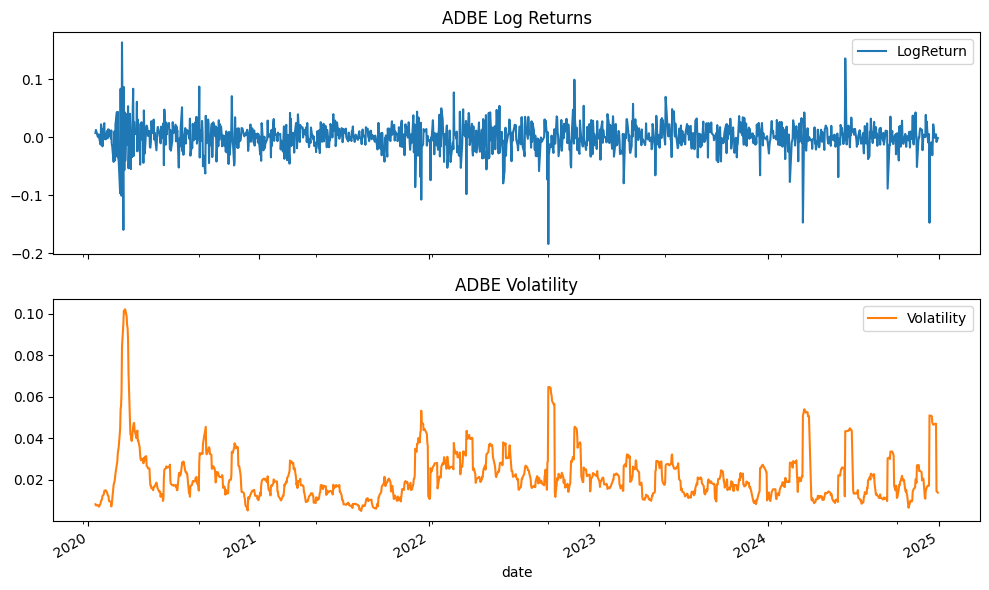

In [9]:
# Plot sample ticker return and volatility
df.plot(subplots=True, title=[f"{sample_ticker} Log Returns", f"{sample_ticker} Volatility"], figsize=(10, 6))
plt.tight_layout()
plt.show()

Preparing the for LSTM for each asset 

In [11]:
# We'll store data for each ticker separately
sequence_data = {}

SEQ_LEN = 30

for ticker in volatility.columns:
    # Combine log returns and volatility for the asset
    asset_df = pd.DataFrame({
        'LogReturn': log_returns[ticker],
        'Volatility': volatility[ticker]
    }).dropna()
    
    # Scale volatility
    scaler = MinMaxScaler()
    scaled_vol = scaler.fit_transform(asset_df[['Volatility']])
    
    # Create sequences
    X, y = [], []
    for i in range(SEQ_LEN, len(scaled_vol)):
        X.append(scaled_vol[i-SEQ_LEN:i])
        y.append(scaled_vol[i])
    
    # Only add if sufficient data exists
    if len(X) > 0:
        X = np.array(X)
        y = np.array(y)
        split = int(0.8 * len(X))
        sequence_data[ticker] = {
            'X_train': X[:split],
            'X_test': X[split:],
            'y_train': y[:split],
            'y_test': y[split:],
            'scaler': scaler
        }

# Show available tickers with sufficient data
print(f"Prepared LSTM-ready data for {len(sequence_data)} assets:")
print(list(sequence_data.keys())[:5])  # Show sample tickers


Prepared LSTM-ready data for 92 assets:
['AAPL', 'ADBE', 'ADI', 'ADP', 'AEP']
